# **Data Modelling and Evaluation**

---

## Objectives

* Answer business requirement 2: 
    * The client seeks to predict whether a cherry leaf is healthy or infected with powdery mildew.

## Inputs

* inputs/cherry_leaves_dataset/cherry-leaves/train
* inputs/cherry_leaves_dataset/cherry-leaves/test
* inputs/cherry_leaves_dataset/cherry-leaves/validation
* image shape embeddings

## Outputs

* Images distribution plot in train, validation, and test set
* Image augmentation
* Class indices to change prediction inference in labels
* Machine learning model creation and training
* Save model
* Learning curve plot for model performance
* Model evaluation on pickle file
* Prediction on the random image file





## Additional Comments:

N/A


---

## 1. Set Data Directory and Import Libraries

---

Import libraries

In [52]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
import joblib

---

## 2. Set working directory

---

In [53]:
cwd= os.getcwd()

In [54]:
os.chdir('/workspace/Portfolio_5_Cherry_Leaves_Mildew')
print("You set a new current directory")

You set a new current directory


In [55]:
work_dir = os.getcwd()
work_dir

'/workspace/Portfolio_5_Cherry_Leaves_Mildew'

---

## 3. Set input directories (Train, Validation, Test)

---

Set train, validation and test paths.

In [56]:
my_data_dir = 'inputs/cherry_leaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

---

## 4. Set output directory

---

In [57]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
  print('Old version is already available create a new version.')
  pass
else:
  os.makedirs(name=file_path)


Old version is already available create a new version.


---

## 5. Set label names

---

Set labels

In [58]:
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['healthy', 'powdery_mildew']


---

## 6. Set image shape

---

Import saved image shape embedding

In [59]:
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(50, 50)

---

## 7. Load Images from Train, Test, and Validation Sets

---

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 315 images
* validation - powdery_mildew: 315 images
* test - healthy: 317 images
* test - powdery_mildew: 317 images




/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


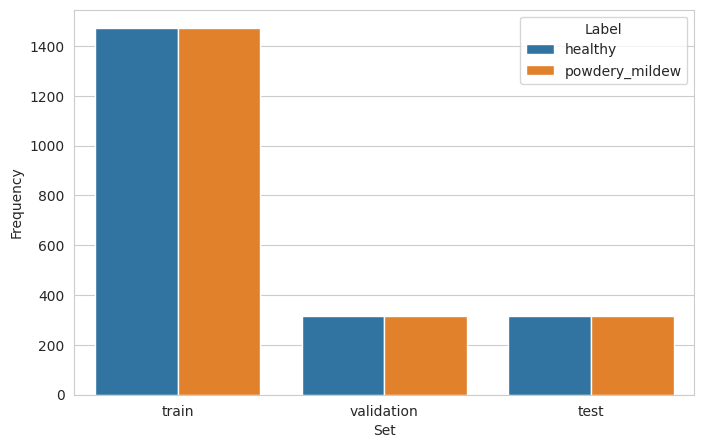

In [60]:
data = []  # List to store data
for folder in ['train', 'validation', 'test']:
    for label in labels:
        num_images = len(os.listdir(os.path.join(my_data_dir, folder, label)))
        data.append({'Set': folder, 'Label': label, 'Frequency': num_images})
        print(f"* {folder} - {label}: {num_images} images")

# Create DataFrame from the accumulated data
df_freq = pd.DataFrame(data)

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()


---

## 8. Image Data Augmentation

---

Import ImageDataGenerator

In [61]:
import cv2
import numpy as np
import os
import random

def cv2_image_generator(image_path, batch_size, image_shape, augmentations=None):
    """
    A generator that yields batches of images and their labels using OpenCV for image augmentation.
    
    :param image_path: Path to the directory containing image subdirectories.
    :param batch_size: Number of images to return in each batch.
    :param image_shape: Tuple of (height, width) to resize images.
    :param augmentations: List of augmentation functions to apply.
    :return: Yields a tuple (batch_images, batch_labels).
    """

    # List of all images and labels
    all_images = []
    labels = os.listdir(image_path)
    label_dict = {label: idx for idx, label in enumerate(labels)}

    for label in labels:
        images_in_label = os.listdir(os.path.join(image_path, label))
        for img_name in images_in_label:
            img_path = os.path.join(image_path, label, img_name)
            all_images.append((img_path, label_dict[label]))

    while True:
        # Shuffle images
        random.shuffle(all_images)

        # Generate batches
        for i in range(0, len(all_images), batch_size):
            batch_images = []
            batch_labels = []
            for img_path, label in all_images[i:i+batch_size]:
                img = cv2.imread(img_path)
                img = cv2.resize(img, image_shape)

                # Apply augmentations
                if augmentations:
                    for func in augmentations:
                        img = func(img)

                batch_images.append(img)
                batch_labels.append(label)

            yield np.array(batch_images), np.array(batch_labels)

# Define augmentation functions
def flip_image(image):
    return cv2.flip(image, 1)  # Flip horizontally

def rotate_image(image):
    angle = random.choice([90, 180, 270])
    height, width = image.shape[:2]
    M = cv2.getRotationMatrix2D((width/2, height/2), angle, 1)
    return cv2.warpAffine(image, M, (width, height))

def blur_image(image):
    kernel_size = random.choice([3, 5, 7])  # Randomly choose kernel size (3x3, 5x5, or 7x7)
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

# Example usage
image_gen = cv2_image_generator(train_path, batch_size=32, image_shape=(128, 128), augmentations=[flip_image, rotate_image])

# Fetch a batch of images and labels
images, labels = next(image_gen)


* Intiatize ImageDataGenerator

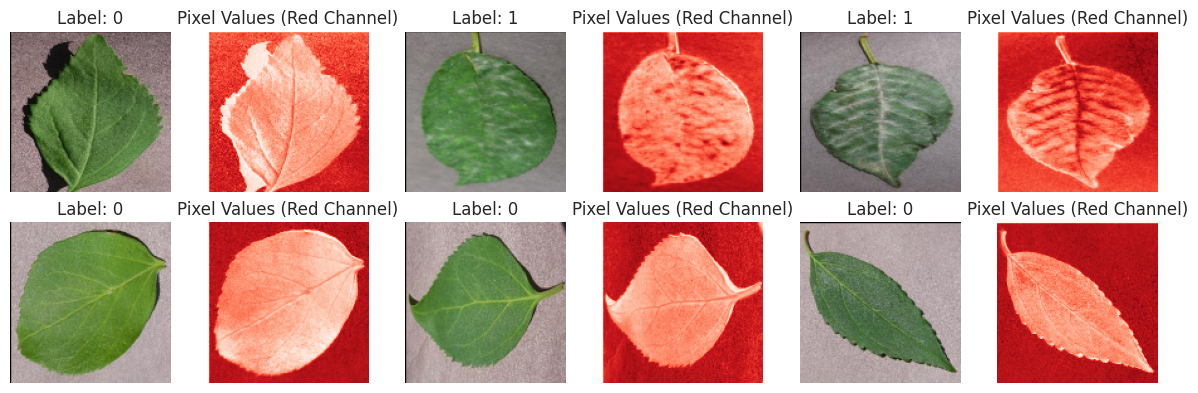

In [73]:
def plot_images_with_pixels(images, labels, n_rows=2, n_cols=3):
    """
    Plot a selection of images with their labels and pixel values.
    
    :param images: Array of images.
    :param labels: Corresponding labels.
    :param n_rows: Number of rows in the plot grid.
    :param n_cols: Number of columns in the plot grid. Each column will have an image and its pixel values.
    """
    fig, axes = plt.subplots(n_rows, n_cols * 2, figsize=(n_cols * 4, n_rows * 2))

    for i in range(n_rows * n_cols):
        # Show image
        ax_img = axes[i // n_cols, (i % n_cols) * 2]
        ax_img.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        ax_img.set_title(f'Label: {labels[i]}')
        ax_img.axis('off')

        # Show pixel values
        ax_pixel = axes[i // n_cols, (i % n_cols) * 2 + 1]
        ax_pixel.imshow(images[i][:,:,0], cmap='Reds')
        ax_pixel.set_title(f'Pixel Values (Red Channel)')
        ax_pixel.axis('off')

    plt.tight_layout()
    plt.show()

# Fetch a batch of images and labels from the generator
images, labels = next(image_gen)

# Plot the images and their pixel values
plot_images_with_pixels(images, labels)


* Augment test image dataset

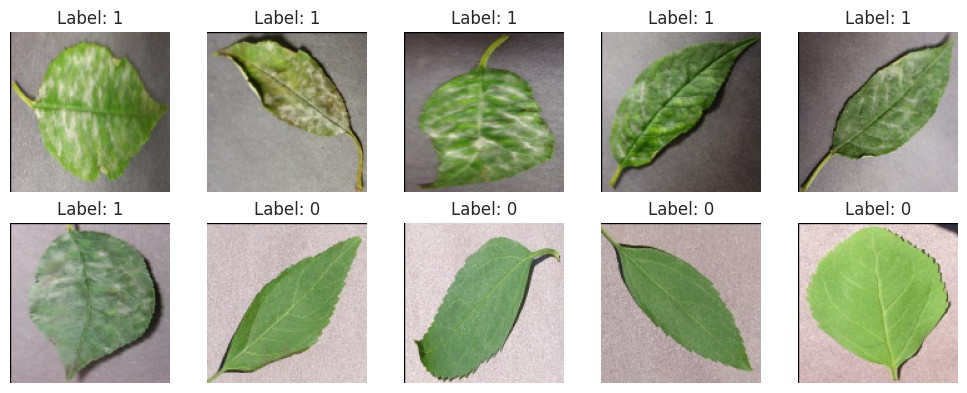

In [63]:
def plot_test_images(image_gen, num_images=10):
    """
    Fetches a batch of images from the generator and plots them.
    
    :param image_gen: The image generator function.
    :param num_images: Number of images to plot.
    """
    images, labels = next(image_gen)  # Fetch a batch of images and labels

    # Number of rows and columns for subplot
    n_cols = 5
    n_rows = num_images // n_cols + (num_images % n_cols > 0)

    plt.figure(figsize=(n_cols * 2, n_rows * 2))

    for i in range(num_images):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))  # Convert color space from BGR to RGB
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Create your image generator for the test set
test_image_gen = cv2_image_generator(test_path, batch_size=10, image_shape=(128, 128), augmentations=[flip_image, rotate_image])

# Plot augmented test images
plot_test_images(test_image_gen, num_images=10)


* Augment train image dataset

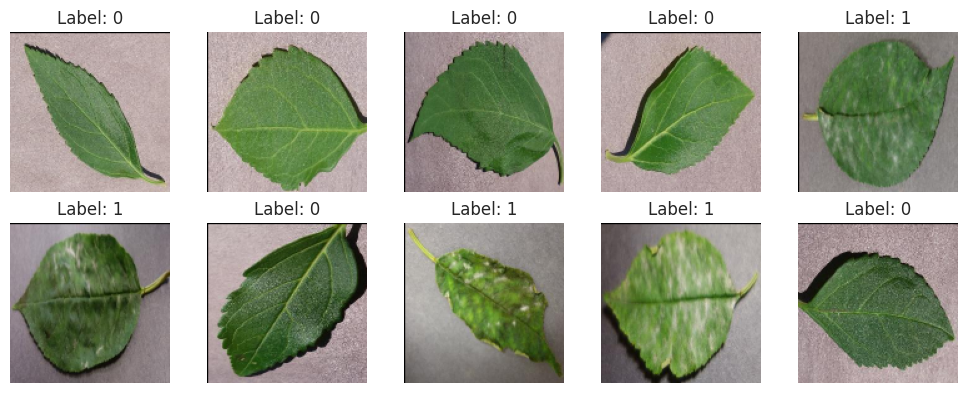

In [64]:
def plot_train_images(image_gen, num_images=10):
    """
    Fetches a batch of images from the generator and plots them.
    
    :param image_gen: The image generator function.
    :param num_images: Number of images to plot.
    """
    images, labels = next(image_gen)  # Fetch a batch of images and labels

    # Number of rows and columns for subplot
    n_cols = 5
    n_rows = num_images // n_cols + (num_images % n_cols > 0)

    plt.figure(figsize=(n_cols * 2, n_rows * 2))

    for i in range(num_images):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))  # Convert color space from BGR to RGB
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Create your image generator for the validation set
validation_image_gen = cv2_image_generator(train_path, batch_size=10, image_shape=(128, 128), augmentations=[flip_image, rotate_image])

# Plot validation images
plot_train_images(validation_image_gen, num_images=10)


* Augment validation image dataset

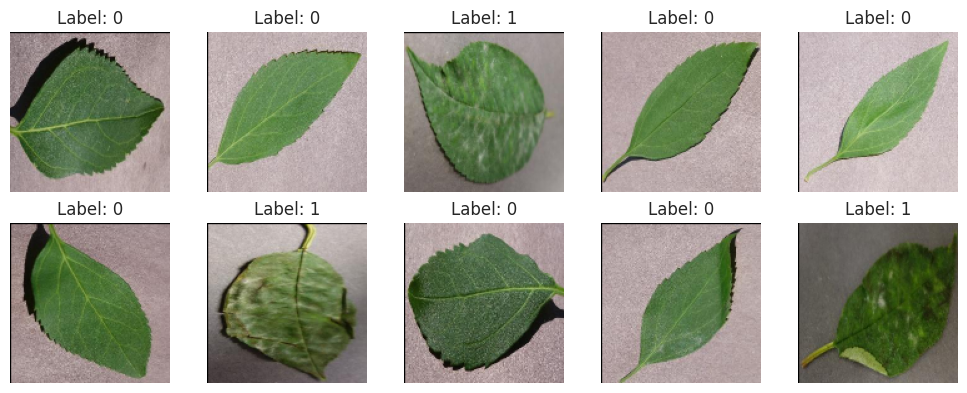

In [65]:
def plot_validation_images(image_gen, num_images=10):
    """
    Fetches a batch of images from the generator and plots them.
    
    :param image_gen: The image generator function.
    :param num_images: Number of images to plot.
    """
    images, labels = next(image_gen)  # Fetch a batch of images and labels

    # Number of rows and columns for subplot
    n_cols = 5
    n_rows = num_images // n_cols + (num_images % n_cols > 0)

    plt.figure(figsize=(n_cols * 2, n_rows * 2))

    for i in range(num_images):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))  # Convert color space from BGR to RGB
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Create your image generator for the validation set
validation_image_gen = cv2_image_generator(val_path, batch_size=10, image_shape=(128, 128), augmentations=[flip_image, rotate_image])

# Plot validation images
plot_validation_images(validation_image_gen, num_images=10)


---

## 9. Save Class Indices

---

In [74]:
class_indices = {'healthy': 0, 'powdery_mildew': 1} 

# Save the class indices to a file using joblib or any other suitable method
joblib.dump(class_indices, f'{file_path}/class_indices.pkl')

['outputs/v1/class_indices.pkl']

---

## 10. Model Creation and Training

---

Advanced model and hyperparameter tuning using GridSearchCV


---

## 11. Save the Model


---

 Save the trained RandomForestClassifier using joblib

---

## 12. Plot Learning Curve for Model Performance

---

### Model learning curve

---

## 13. Model Evaluation on Test Data

---

Load saved model

Evaluate model on test set

Save evaluation pickle

---

## 14. Prediction on a Random Image File

---

Load a random image as PIL

Convert image to array and prepare for prediction

Predict class probabilities

---

## 15. Push Files to Repo (Git Commands)

---

#### Push generated/new files from this Session to GitHub repo

* .gitignore

In [ ]:
!cat .gitignore

* Git status

In [ ]:
!git status

* Git add

In [ ]:
!git add .

* Git commit

In [ ]:
!git commit -am " Add new plots- test run"

* Git Push

In [ ]:
!git push